# Cavendish

In [1]:
from pre_process import *
from outcome import *
import csv
import os
from matplotlib.backend_bases import MouseButton
import matplotlib.pyplot as plt
from libtiff import TIFF

## PreProcess Data

### Preview Image to Determine y-bound

In [2]:
%matplotlib qt
file_location = "./s1/pos1_1.tif"
tif = TIFF.open(file_location)
image = preview_images("./s1/pos1_1.tif", 1, plotting=False)



fig, ax = plt.subplots(figsize=(20, 5))
ax.imshow(image)


def on_move(event):
    pass
        

meter_stick_cm = [i for i in range(3, 58, 1)]
meter_stick_pix = []


def on_click(event):
    if event.button is MouseButton.LEFT:
        print(f'data coords {event.xdata} {event.ydata}')
        meter_stick_pix.append(event.xdata)
        plt.disconnect(binding_id)


binding_id = plt.connect('motion_notify_event', on_move)
plt.connect('button_press_event', on_click)

plt.show()

In [4]:
if len(meter_stick_pix) == len(meter_stick_cm):
    print("Writting into csv")
    file = open('map_meter.csv', 'w+', newline ='')
    with file:   
        write = csv.writer(file)
        write.writerows([[meter_stick_cm[i], meter_stick_pix[i]] for i in range(len(meter_stick_cm))])
        

else:
    print("Getting results from csv")
    meter_stick_pix = []
    meter_stick_cm = []
    with open(f"map_meter.csv") as csvfile:
        read_data = csv.reader(csvfile, delimiter=',')
        for row in read_data:
            meter_stick_cm.append(float(row[0]))
            meter_stick_pix.append(float(row[1]))

### Find Displacement of Laser Dot and Plot All Graphs

In [6]:
y_bound = [0, 27]
folder = ["./s1/", "./s2/"]

f_location = [[] for i in range(len(folder))]
for i in range(len(folder)):
    count = 0
    for path in os.listdir(folder[i]):
        if os.path.isfile(os.path.join(folder[i], path)):
            count += 1
    for j in range(count):
        f_location[i].append(folder[i] + f"pos{i+1}_{j+1}.tif")


x_list = [[] for i in range(len(folder))]
y_list = [[] for i in range(len(folder))]
for i in range(len(f_location)):
    for j in range(len(f_location[i])):
        pix_pos, img_num = gen_pix_pos(f_location[i][j], y_bound)
        pos_cm = get_x_new(pix_pos, meter_stick_pix, meter_stick_cm)
        T = 5
        x, y = plot_dots(img_num, pos_cm, T)
        x_list[i].append(x)
        y_list[i].append(y)
        
        plt.title(f"{f_location[i][j]}")



### Save data to csv

In [7]:
m_length = 0
for i in range(len(x_list)):
    for j in range(len(x_list[i])):
        max_length = len(x_list[i][j])
        if max_length >= m_length:
            m_length = max_length
print(m_length)

In [8]:
csv_input = [[0 for i in range(2*(len(x_list[0]) + len(x_list[1])))] for p in range(m_length)]
enumerator = -1
for i in range(len(x_list)):
    cond = 1
    for j in range(len(x_list[i])*2):
        map_j = int(j/2)
        enumerator += 1
        cond *= -1
        for k in range(len(x_list[i][map_j])):
            if cond < 0:
                csv_input[k][enumerator] = x_list[i][map_j][k]
            elif cond > 0:
                csv_input[k][enumerator] = y_list[i][map_j][k]


file = open('laser_pos_data.csv', 'w+', newline ='')
with file:   
    write = csv.writer(file)
    write.writerows(csv_input)

### Write data from csv

In [2]:
x_1 = []
y_1 = []
x_2 = []
y_2 = []
with open("laser_pos_data.csv") as csvfile:
    read_data = csv.reader(csvfile, delimiter=',')
    for row in read_data:
        x_1.append(int(row[0]))
        x_2.append(int(row[2]))
        y_1.append(float(row[1]))
        y_2.append(float(row[3]))

x_1.pop()
y_1.pop()
x_list = np.array([[x_1], [x_2]])
y_list = np.array([[y_1], [y_2]])


/tmp/ipykernel_43075/1430463923.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_list = np.array([[x_1], [x_2]])
/tmp/ipykernel_43075/1430463923.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_list = np.array([[y_1], [y_2]])


### Save figures

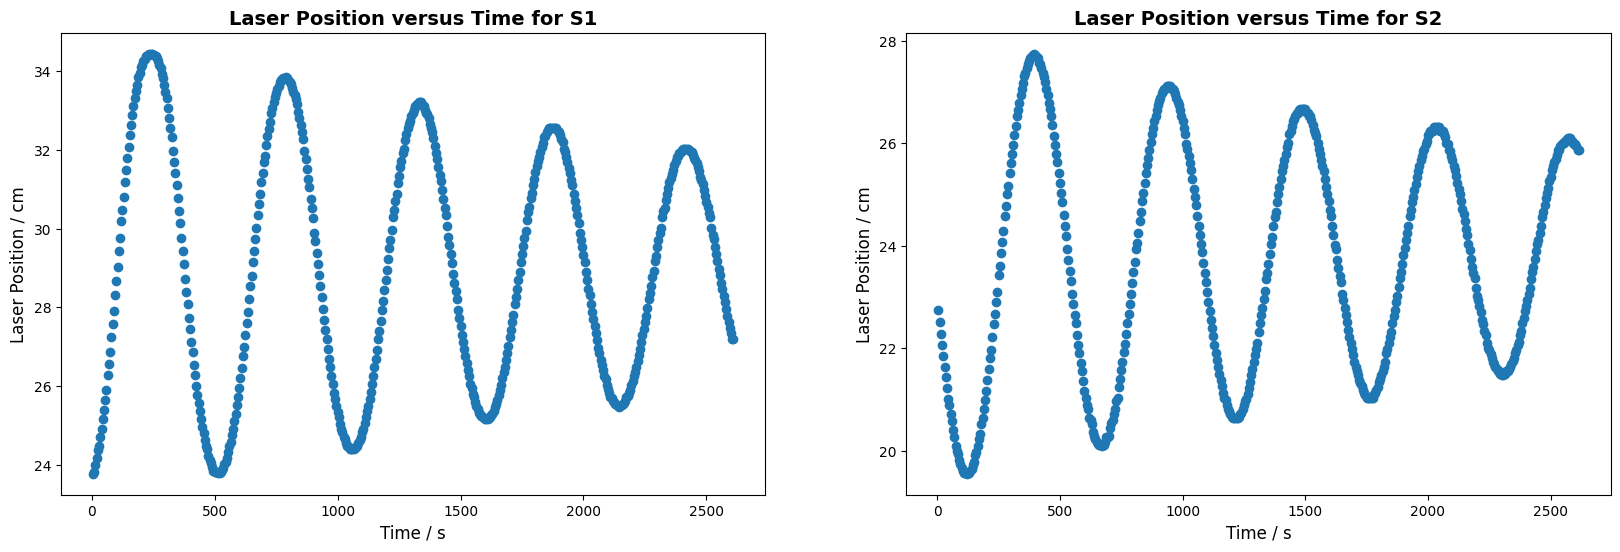

In [15]:
fig, ax = plt.subplots(1, 2,figsize=(20, 6))
ax[0].scatter(x_list[0][0], y_list[0][0])
ax[0].set_title(f"Laser Position versus Time for S1", fontweight="bold", fontsize=14)
ax[0].set_ylabel("Laser Position / cm", fontsize=12)
ax[0].set_xlabel("Time / s", fontsize=12)

ax[1].scatter(x_list[1][0], y_list[1][0])
ax[1].set_title(f"Laser Position versus Time for S2", fontweight="bold", fontsize=14)
ax[1].set_ylabel("Laser Position / cm", fontsize=12)
ax[1].set_xlabel("Time / s", fontsize=12)

plt.savefig("raw_data_combined")


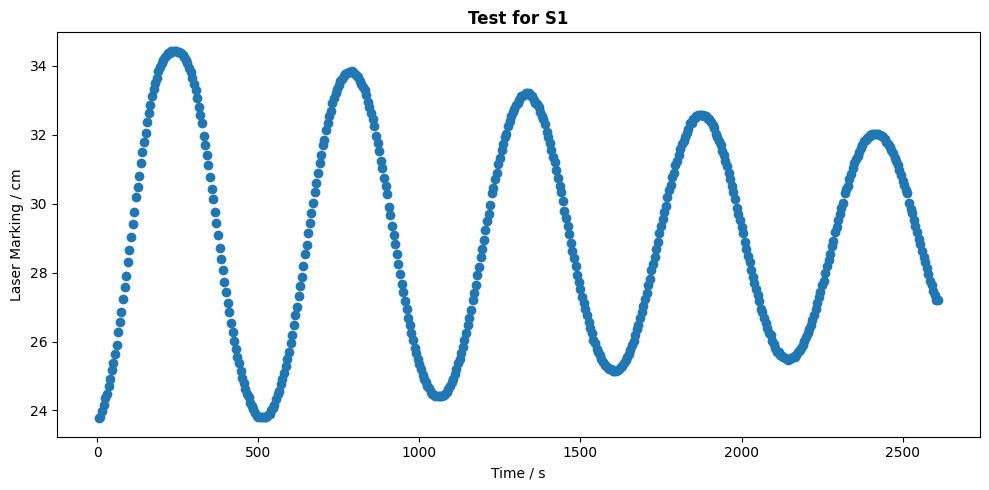

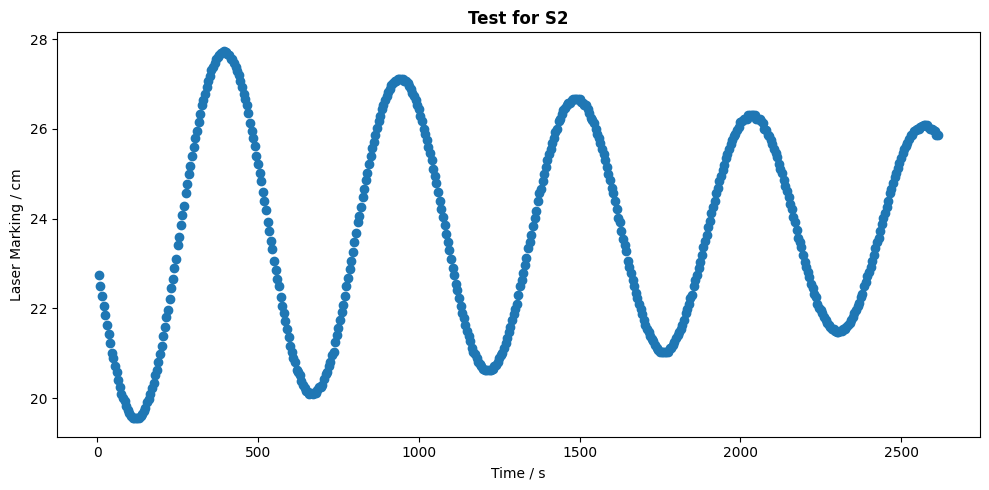

In [10]:
def out_r_c(index, cap):
    r, c = 0, 0
    for i in range(index):
        if r < cap:
            r += 1
        else:
            c += 1
            r = 0
    return r, c


for i in range(len(x_list)):
    fig, ax = plt.subplots(figsize=(10, 5))
    for j in range(len(x_list[i])):
        ax.scatter(x_list[i][j], y_list[i][j])
        ax.set_title(f"Test for S{i+1}", fontweight="bold")
        ax.set_ylabel("Laser Marking / cm")
        ax.set_xlabel("Time / s")
        plt.tight_layout()
    # plt.savefig(f"Scatter Plot for S{i+1}")

## Calcualte Big G

### Calculate delta_S and T for S1

In [38]:
x = np.array(x_list[0][0])
y = np.array(y_list[0][0])

Text(0, 0.5, 'Displacement / m')

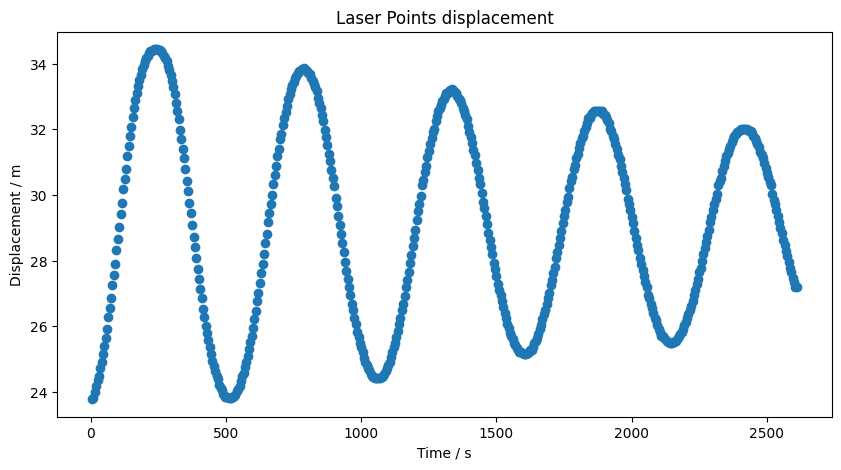

In [39]:
# Pick desired region to fit
start = 0
x, y = x[start:], y[start:]
plt.figure(figsize=(10, 5))
plt.scatter(x, y)
plt.title("Laser Points displacement")
plt.xlabel("Time / s")
plt.ylabel("Displacement / m")

amplitude = -6.041937280753209 +- 0.17804333900496577
decay_const = 0.00026878049832281675 +- 2.3798629359875814e-05
ang_freq = 0.011532666918316635 +- 2.217450525747366e-05
phase = 6.636280680375868 +- 0.02752357677752523
const = 28.922556747825336 +- 0.05194334781208184


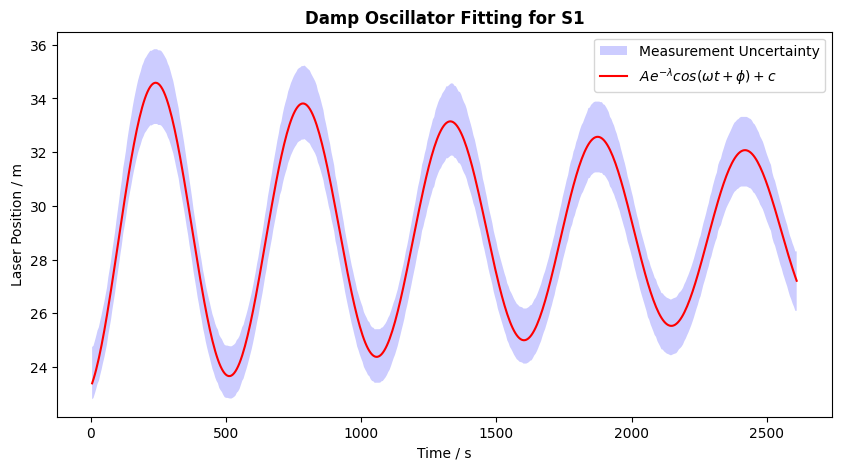

In [40]:
def func(t, a, lamb, gamma, phi, c):
    return a * np.exp(-lamb*t) * np.cos(gamma*t + phi) + c


# assuming uncertainty to be 0.2
y_uncer = np.array([np.sqrt(0.2**(2) + (y[i]*0.04)**(2))  for i in range(len(y))])
ang_freq1, const_s1, ang_freq1_uncer, const_s1_uncer = get_fit_para(func, x, y, y_uncer, name="Damp Oscillator Fitting for S1", save_fig=True)

### Calculate delta_S and T for S2

In [42]:
x = np.array(x_list[1][0])
y = np.array(y_list[1][0])

Text(0, 0.5, 'Displacement / m')

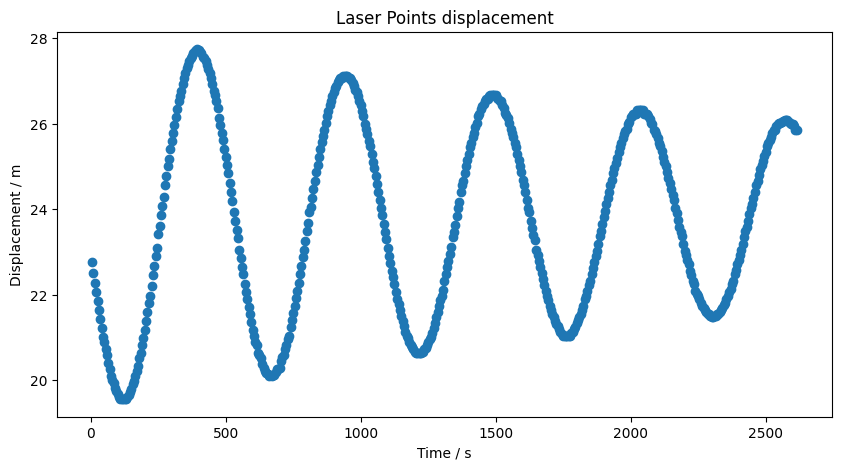

In [43]:
start = 0
x, y = x[start:], y[start:]
plt.figure(figsize=(10, 5))
plt.scatter(x, y)
plt.title("Laser Points displacement")
plt.xlabel("Time / s")
plt.ylabel("Displacement / m")

amplitude = 4.390123122034115 +- 0.13474724395110324
decay_const = 0.0002702790123178459 +- 2.4765813101654635e-05
ang_freq = 0.011503824194760058 +- 2.6260854229195422e-05
phase = 1.7174422362282815 +- 0.032049314864118085
const = 23.803148817464283 +- 0.043329537997019406


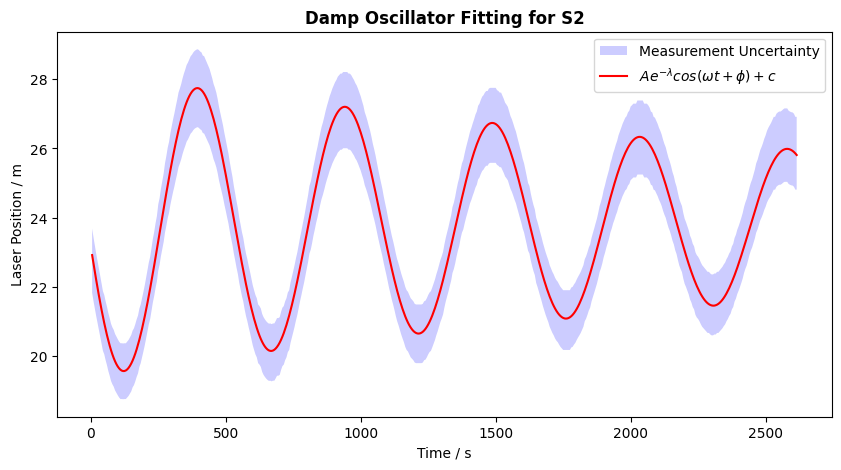

In [44]:
y_uncer = np.array([np.sqrt(0.2**(2) + (y[i]*0.04)**(2))  for i in range(len(y))])
ang_freq2, const_s2, ang_freq2_uncer, const_s2_uncer = get_fit_para(func, x, y, y_uncer, name="Damp Oscillator Fitting for S2", save_fig=True)

### Evaluating G by Stationary Position

In [20]:
s1 = const_s1
s2 = y_list[0][0][0]
delta_S = abs(s1-s2) / 100
T = 2*np.pi/((ang_freq1+ang_freq2)/2)
print(f"s1 = {s1}, s2 = {s2}, Delta_S = {delta_S*100} cm \nPeriod = {T/60} mins or {T} second")

s1 = 28.90646003395616, s2 = 23.770309305988402, Delta_S = 5.13615072796776 cm 
Period = 9.08482150904579 mins or 545.0892905427474 second


In [21]:
L = 1.74625
G = 6.67428 * 10**(-11)

G_cal = get_G(delta_S, T, L)
frac_diff_cal = abs(G_cal - G)/G

beta = cal_corr()
G_correct = G_cal/(1-beta)
frac_diff_correct = abs(G_correct - G)/G

print(f"G is calculated to be {G_cal} withouht the correction factor with a percentage differencce of {np.round(frac_diff_cal*100, 3)}%\n"
      f"G is calculated to be {G_correct} withouht the correction factor with a percentage differencce of {np.round(frac_diff_correct*100, 3)}%")
print(f"The factor without L, T and delta_S is {G_correct * L * T ** 2 / delta_S}")

G is calculated to be 5.8842489653047e-11 withouht the correction factor with a percentage differencce of 11.837%
G is calculated to be 6.251674490468982e-11 withouht the correction factor with a percentage differencce of 6.332%
The factor without L, T and delta_S is 0.0006315392035097625


### Evaluating G by Oscillatory Equilibrium Position

In [75]:
s1 = const_s1
s2 = const_s2
delta_S = abs(s1-s2) / 100
T = 2*np.pi/((ang_freq1+ang_freq2)/2)
print(f"s1 = {s1}, s2 = {s2}, Delta_S = {delta_S*100} cm \nPeriod = {T/60} mins")

s1 = 28.922556747825336, s2 = 23.803148817464283, Delta_S = 5.119407930361053 cm 
Period = 9.09164113628533 mins


In [105]:
L = 1.74625
G = 6.67428 * 10**(-11)

G_cal = get_G(5.293/100, T, L)
frac_diff_cal = abs(G_cal - G)/G

beta = cal_corr()
G_correct = G_cal/(1-beta)
G_e = G_correct
G_e_uncer = 0.3 * 10**(-11)
frac_diff_correct = abs(G_correct - G)/G

print(f"G is calculated to be {G_cal} withouht the correction factor with a percentage differencce of {round(frac_diff_cal*100, 3)}%\n"
      f"G is calculated to be {G_correct} withouht the correction factor with a percentage differencce of {round(frac_diff_correct*100, 3)}%")

G is calculated to be 6.054850180249729e-11 withouht the correction factor with a percentage differencce of 9.281%
G is calculated to be 6.432928422755585e-11 withouht the correction factor with a percentage differencce of 3.616%


In [77]:
def compute_theta(s1, s2):
    c = 29
    L = 1.74625 * 100
    l1 = np.sqrt(L**(2) + (s1 - c)**(2))
    l2 = np.sqrt(L**(2) + (s2 - c)**(2))
    nominator = (s1 - s2)**(2) - l1**(2) - l2**(2)
    denominator = -2 * l1 * l2
    print(l2-l1)
    theta = np.arccos(nominator/denominator)/4
    return theta



def get_G_new(theta, T, L):
    b = 42.2 / 1000
    d = 50 / 1000
    r = 9.55 / 1000
    m1 = 1.5
    factor = np.pi ** (2) * 4 * L * theta * b ** (2)
    nominator = d**(2) + (2/5) * r ** 2
    denominator = T**2 * m1 * L * d
    beta = b**(3) / (b**(2) + 4 * d**(2))**(3/2)
    return factor * nominator / denominator

In [78]:
L = 1.74625
G = 6.67428 * 10**(-11)

s1 = const_s1
s2 = const_s2

T = 2*np.pi/((ang_freq1+ang_freq2)/2)
print(f"s1 = {s1}, s2 = {s2}, Delta_S = {delta_S*100} cm \nPeriod = {T/60} mins or {T} second")


theta = compute_theta(s1, s2)
G_cal = get_G_new(theta, T, L)
frac_diff_cal = abs(G_cal - G)/G

beta = cal_corr()
G_correct = G_cal/(1-beta)
frac_diff_correct = abs(G_correct - G)/G

print(f"G is calculated to be {G_cal} withouht the correction factor with a percentage differencce of {round(frac_diff_cal*100, 3)}%\n"
      f"G is calculated to be {G_correct} withouht the correction factor with a percentage differencce of {round(frac_diff_correct*100, 3)}%")

s1 = 28.922556747825336, s2 = 23.803148817464283, Delta_S = 5.119407930361053 cm 
Period = 9.09164113628533 mins or 545.4984681771199 second
0.07729502528417243
G is calculated to be 5.854517955932609e-11 withouht the correction factor with a percentage differencce of 12.282%
G is calculated to be 6.220087011087442e-11 withouht the correction factor with a percentage differencce of 6.805%


### Evaluate G by acceleration

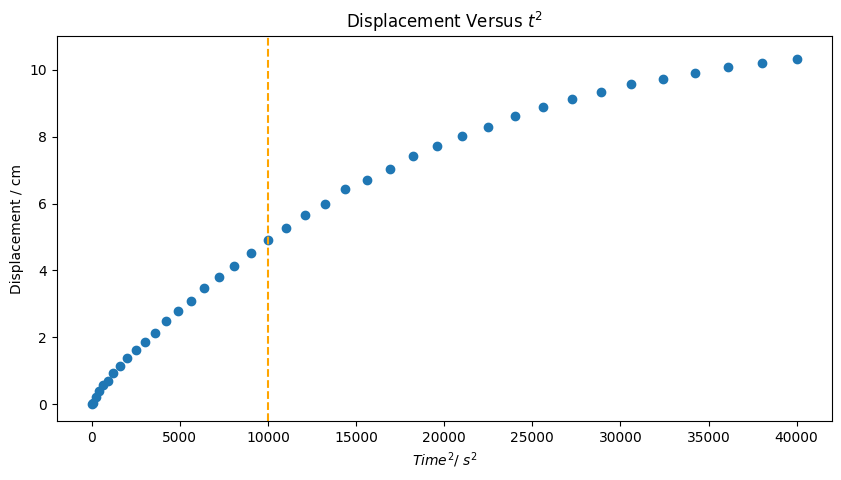

In [79]:
x = np.array(x_list[0][0]) ** (2)
y = np.array(y_list[0][0]) - y_list[0][0][0]
start = 0
end = 40
x, y = x[start:end], y[start:end]
plt.figure(figsize=(10, 5))
plt.scatter(x, y)
plt.plot([10000 for i in range(30)], [i/2 for i in range(-1, 29, 1)], "--", color="orange")
plt.ylim(-0.5, 11)

plt.title(r"Displacement Versus $t^{2}$")
plt.xlabel(r"$Time ^ {2}$/ $s^{2}$")
plt.ylabel("Displacement / cm")
plt.savefig("S1_acceleration")


Text(0, 0.5, 'Displacement / m')

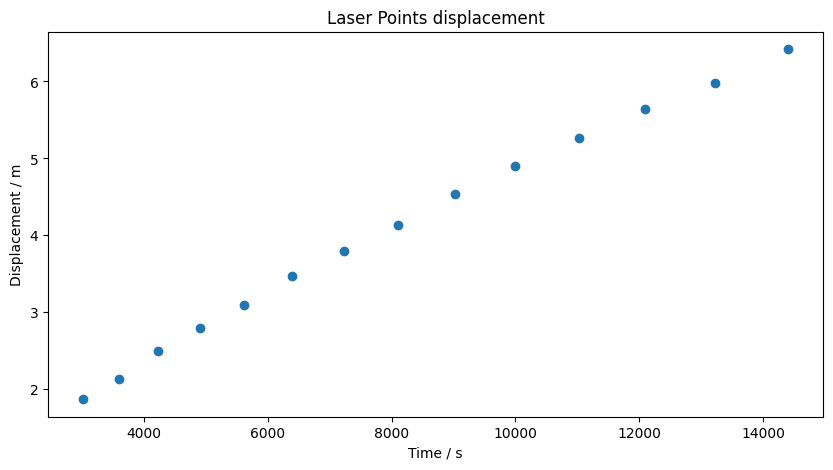

In [80]:
x = np.array(x_list[0][0])
x = x**2
y = np.array(y_list[0][0]) - y_list[0][0][0]
start = 10
end = 24
x, y = x[start:end], y[start:end]
plt.figure(figsize=(10, 5))
plt.scatter(x, y)
plt.title("Laser Points displacement")
plt.xlabel("Time / s")
plt.ylabel("Displacement / m")

gradient = 0.00040445200308602164 +- 2.021505775258524e-05
constant = 0.7795632041894973 +- 0.15981844285661242


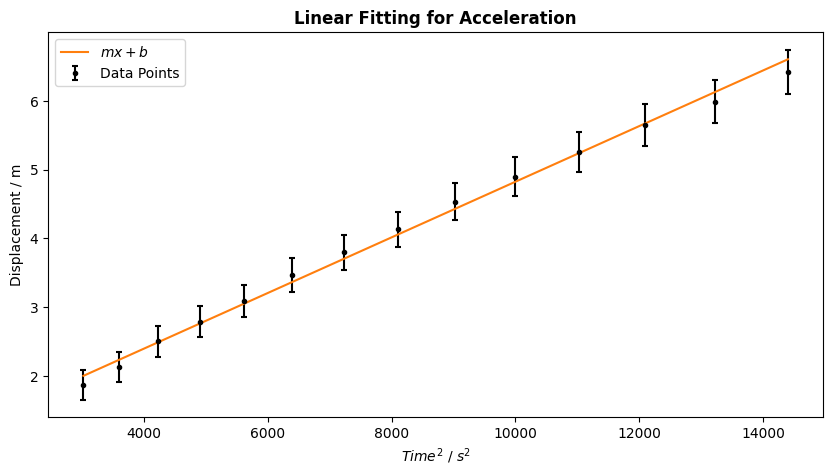

In [82]:
def func(t, m, b):
    return m*t + b

y_uncer = np.array([np.sqrt(0.2**(2) + (y[i]*0.04)**(2))  for i in range(len(y))])
grad, const = linear_fit(func, x, y, y_uncer, name="Linear Fitting for Acceleration", save_fig=False)

In [83]:
L = 1.74625
G = 6.67428 * 10**(-11)

G_cal = get_G_by_a(grad, L)
frac_diff_cal = abs(G_cal - G)/G

beta = cal_corr()
G_correct = G_cal/(1-beta)
G_a = G_correct
G_a_uncer = 0.4 * 10 **(-11)
frac_diff_correct = abs(G_correct - G)/G

print(f"G is calculated to be {G_cal} withouht the correction factor with a percentage differencce of {round(frac_diff_cal*100, 3)}%\n"
      f"G is calculated to be {G_correct} withouht the correction factor with a percentage differencce of {round(frac_diff_correct*100, 3)}%\n"
      f"without the factor gradient and Length {G_correct * L / grad}")

G is calculated to be 6.874390886907285e-11 withouht the correction factor with a percentage differencce of 2.998%
G is calculated to be 7.303643064491796e-11 withouht the correction factor with a percentage differencce of 9.43%
without the factor gradient and Length 3.1533993166195776e-07


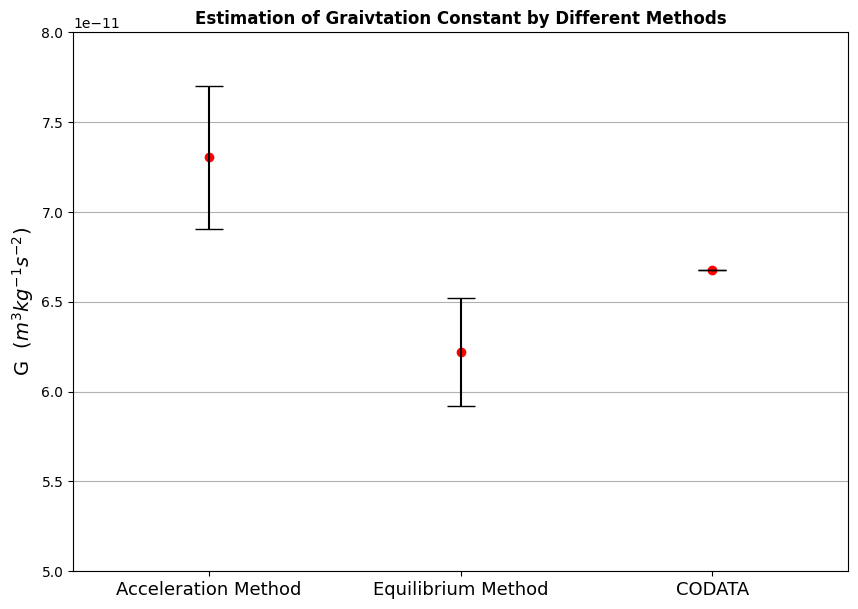

In [103]:
G_c = 6.67430 * 10**(-11) 
G_c_uncer = 0.00015 * 10**(-11)

y_bar = [G_a, G_e, G_c]
y_uncer = [G_a_uncer, G_e_uncer, G_c_uncer]
bar_label = ["Acceleration Method", "Equilibrium Method", "CODATA"]
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter([0, 1, 2], y_bar, color='r')
ax.bar(np.arange(len(y_bar)), y_bar, yerr=y_uncer, align='center', alpha=0.0, ecolor='black', capsize=10)
ax.set_ylabel('G  ($m^{3}kg^{-1}s^{-2}$)', fontsize=14)
ax.set_xticks(np.arange(len(y_bar)))
ax.set_xticklabels(bar_label, fontsize=13)
ax.set_ylim(5 * 10 **(-11), 8 * 10 **(-11))
ax.set_title('Estimation of Graivtation Constant by Different Methods', fontweight="bold")
ax.yaxis.grid(True)
plt.savefig("prediction_compare")